<center>
<h1><b>Homework 3</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>October 16, 2020</b></h3>
</center>
<hr>

# Problem 1
## 4.10 (p.113)
Calculate the precession of the perihelion of Mercury, following the approach described in this section.

Only consider the correction coming from general relativity (ignore other Solar System planets).

In [1]:
sun_mass = 1.9885e30  # [kg]
earth_mass = 5.97e24  # [kg]
moon_mass = 7.3459e22  # [kg]
G = 6.67408e-11  # [Nm^2/kg^2]
AU = 149597870700  # [m/s]
year = 365.25636  # [day]
day = 86400  # [s]

sun_radius = 6.957e8  # [m]
mercury_radius = 2.44e6  # [m]
smallest_radius = min(sun_radius, mercury_radius)

In [2]:
from scipy.integrate import solve_ivp
from functools import partial
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from astroquery.jplhorizons import Horizons
import astropy as astr

np.set_printoptions(sign=' ', linewidth=100, precision=4, suppress=True)
plt.style.use('dark_background')

In [3]:
sun     = Horizons( id=10, location='@sun', id_type='majorbody')
mercury = Horizons(id=199, location='@sun', id_type='majorbody')
astr.table.vstack([sun.vectors(), mercury.vectors()])

targetname,datetime_jd,datetime_str,x,y,z,vx,vy,vz,lighttime,range,range_rate
---,d,---,AU,AU,AU,AU / d,AU / d,AU / d,d,AU,AU / d
str13,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64
Sun (10),2459149.650369481,A.D. 2020-Oct-27 03:36:31.9232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mercury (199),2459149.650390692,A.D. 2020-Oct-27 03:36:33.7558,0.2419555329149679,0.2069616570155531,-0.005282940472614305,-0.02383022699043795,0.02258204223587076,0.00403128699668719,0.001839151371267078,0.3184391886103636,-0.003496854282024549


In [19]:
M_sun = 1.9885e30  # [kg]
M_mercury = 3.3011e23  # [kg]
G = 6.67408e-11  # [N*kg**(-1)*s**(-2)]
c = 299792458.0  # [m/s]

P = 87.9691  # [days]
AU = 149597870700  # [m]
day = 86400  # [s]

alpha = 1.1e-8
G = 2.959e-4
M_sun /= M_sun
M_mercury/= M_sun

In [20]:
def rhs(t, state, alpha=alpha, G=G):
    r, dr = np.hsplit(state, 2)
    return np.hstack((dr, -G * (1 + alpha / norm(r) ** 2) * r / norm(r) ** 3 ))

In [21]:
obj = Horizons(id=1, location='@sun', id_type='majorbody')
vectors = obj.vectors()
pos = np.asarray([vectors['x'], vectors['y'], vectors['z']]).ravel()
vel = np.asarray([vectors['vx'], vectors['vy'], vectors['vz']]).ravel()

In [22]:
L = np.linalg.norm(np.cross(M_mercury * vel, pos))
df = partial(rhs, alpha=1000*alpha, G=G)
state0 = np.hstack((pos, vel))

In [30]:
t_f = 250 * P

sol = solve_ivp(df, [0, t_f], state0, t_eval=np.linspace(0, t_f, 100 * int(t_f)), rtol=1.0e-6, atol=1.0e-6, method='LSODA')
t, (pos, vel) = sol.t, np.vsplit(sol.y, 2)  # unpack

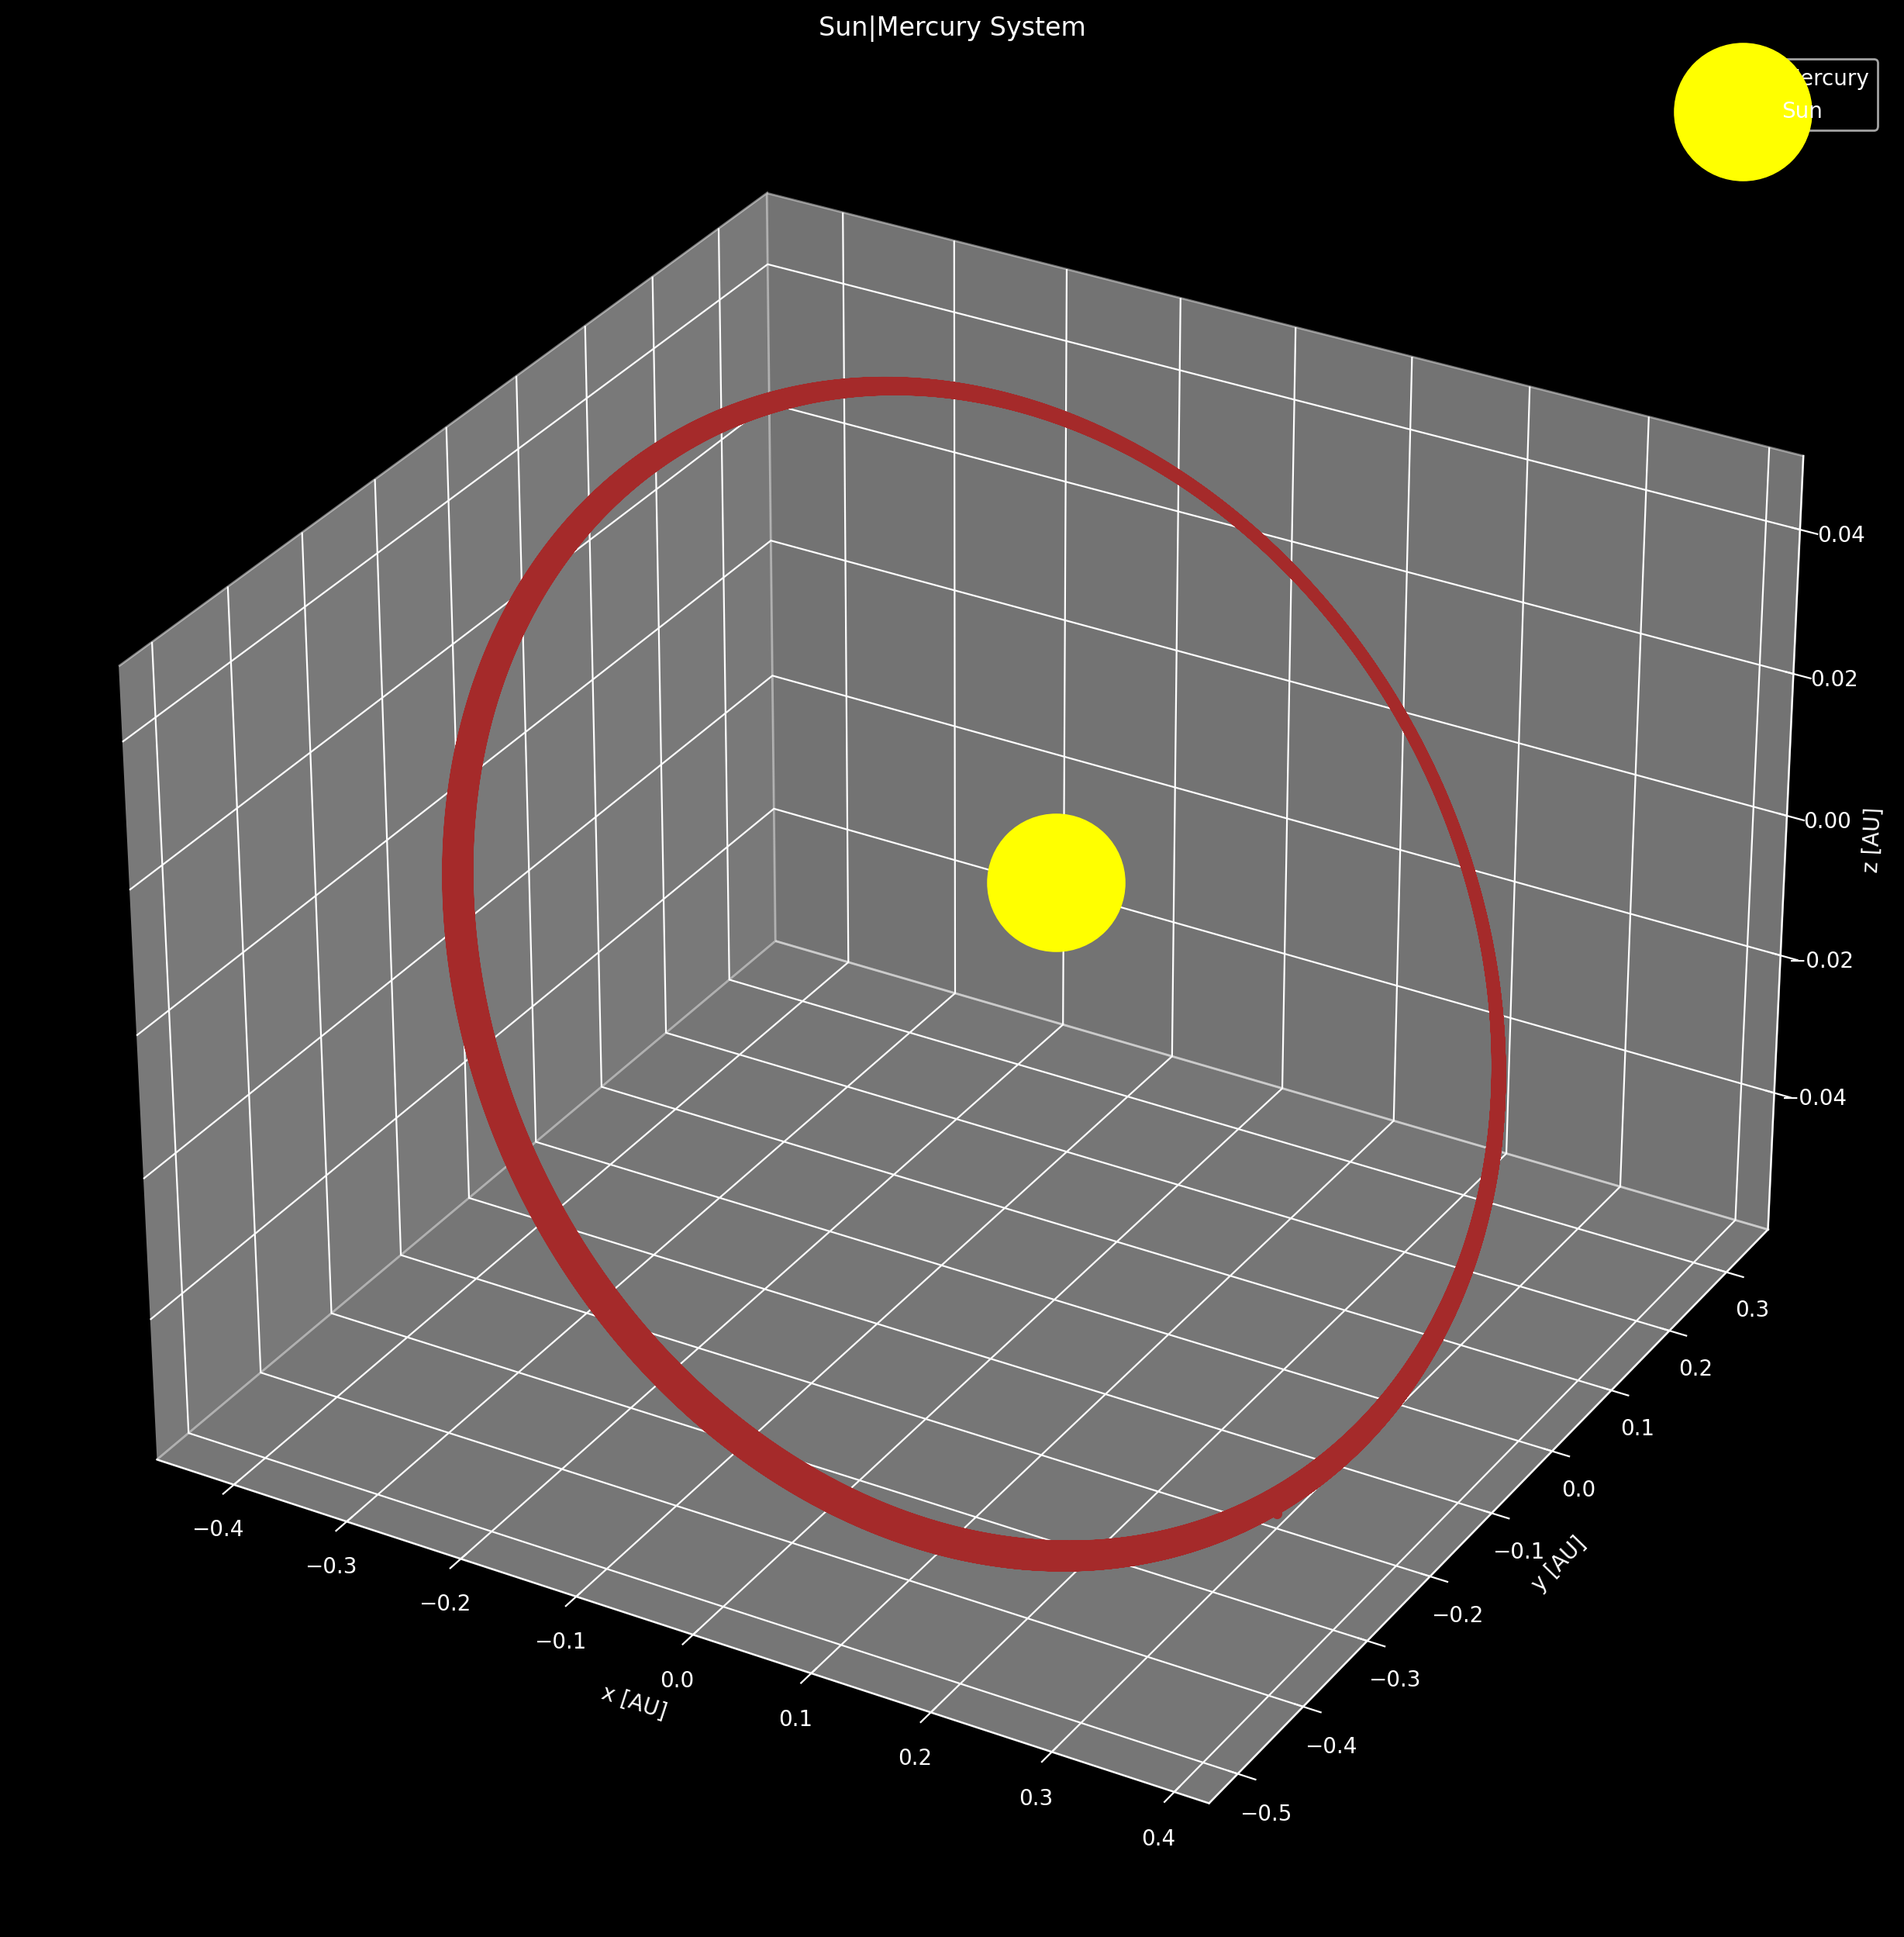

In [31]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Sun|Mercury System')
ax.plot(pos[0,:], pos[1,:], pos[2,:], color='brown')
ax.scatter(pos[0,-1], pos[1,-1], pos[2,-1], label=r'Mercury', color='brown', s=10 * mercury_radius / smallest_radius)
ax.scatter(0, 0, 0, label=r'Sun', color="yellow",  s=10 * sun_radius / smallest_radius)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
plt.legend()
plt.savefig('P1a.png')

# Problem 2
## 4.14 (p.118)

Simulate the orbits of Earth and Moon in the solar system by writing a program that accurately tracks the motions of both as they move about the Sun. Be careful about (1) the different time scales present in this problem, and (2) the correct initial velocities (ie., set the initial velocity of Moon taking into account the motion of Earth around which it rotates).

Also run your code for a hypothetical ”Moon” that has either the same mass as Earth (e.g., binary planets), or a rather elliptical orbit.

In [12]:
sun   = Horizons( id=10, location='@sun', id_type='majorbody')
earth = Horizons(id=399, location='@sun', id_type='majorbody')
moon  = Horizons(id=301, location='@sun', id_type='majorbody')
astr.table.vstack([sun.vectors(), earth.vectors(), moon.vectors()])

targetname,datetime_jd,datetime_str,x,y,z,vx,vy,vz,lighttime,range,range_rate
---,d,---,AU,AU,AU,AU / d,AU / d,AU / d,d,AU,AU / d
str11,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64
Sun (10),2459149.651444358,A.D. 2020-Oct-27 03:38:04.7925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Earth (399),2459149.65145553,A.D. 2020-Oct-27 03:38:05.7578,0.8248656087160192,0.5542517936775117,-2.542370650846111e-05,-0.009877166959799124,0.01420904581573099,-5.557257665859543e-07,0.005739593548191273,0.993779816601018,-0.0002736483355751084
Moon (301),2459149.651468131,A.D. 2020-Oct-27 03:38:06.8465,0.8274493026719698,0.5535655173381269,-0.0002640780644943236,-0.0097144991525688,0.01474987119023275,-7.270494340257783e-06,0.005749780719713085,0.9955436706721514,0.0001273338882099641


In [13]:
sun_mass = 1.9885e30  # [kg]
earth_mass = 5.97e24  # [kg]
moon_mass = 7.3459e22  # [kg]
G = 6.67408e-11  # [Nm^2/kg^2]
AU = 149597870700  # [m/s]
year = 365.25636  # [day]
day = 86400  # [s]

sun_radius = 6.957e8  # [m]
earth_radius = 6.371009e6  # [m]
moon_radius = 1.7374e6  # [m]
smallest_radius = min(sun_radius, earth_radius, moon_radius)

sun_mass /= AU ** 3 / (G * day ** 2)
earth_mass /= AU ** 3 / (G * day ** 2)
moon_mass /= AU ** 3 / (G * day ** 2)

In [14]:
def rhs(t, state, m0=sun_mass, m1=earth_mass, m2=moon_mass):
    r0, r1, r2, dr0, dr1, dr2 = np.hsplit(state, 6)
    return np.hstack((
        dr0, 
        dr1,
        dr2, 
        -m1 * (r0 - r1) / norm(r0 - r1) ** 3 - m2 * (r0 - r2) / norm(r0 - r2) ** 3,
        -m0 * (r1 - r0) / norm(r1 - r0) ** 3 - m2 * (r1 - r2) / norm(r1 - r2) ** 3,
        -m0 * (r2 - r0) / norm(r2 - r0) ** 3 - m1 * (r2 - r1) / norm(r2 - r1) ** 3
        ))

In [15]:
sun_vectors = sun.vectors()
sun_pos = np.asarray([sun_vectors['x'], sun_vectors['y'], sun_vectors['z']]).ravel()
sun_vel = np.asarray([sun_vectors['vx'], sun_vectors['vy'], sun_vectors['vz']]).ravel()

earth_vectors = earth.vectors()
earth_pos = np.asarray([earth_vectors['x'], earth_vectors['y'], earth_vectors['z']]).ravel()
earth_vel = np.asarray([earth_vectors['vx'], earth_vectors['vy'], earth_vectors['vz']]).ravel()

moon_vectors  = moon.vectors()
moon_pos = np.asarray([moon_vectors['x'], moon_vectors['y'], moon_vectors['z']]).ravel()
moon_vel = np.asarray([moon_vectors['vx'], moon_vectors['vy'], moon_vectors['vz']]).ravel()

state0 = np.hstack((sun_pos, earth_pos, moon_pos, sun_vel, earth_vel, moon_vel))

In [16]:
t_f = year
step_density = 100

sol = solve_ivp(rhs, [0, t_f], state0, t_eval=np.linspace(0, t_f, int(step_density * t_f)), rtol=1.0e-4, atol=1.0e-6, method="LSODA")  # Using 'LSODA' to account for the stiffness of the problem
if sol.success is True:
    t, (pos, vel) = sol.t, np.vsplit(sol.y, 2)
    (sun_pos, earth_pos, moon_pos), (sun_vel, earth_vel, moon_vel) = np.vsplit(pos, 3), np.vsplit(vel, 3)
else:
    print('Error!', sol.message)

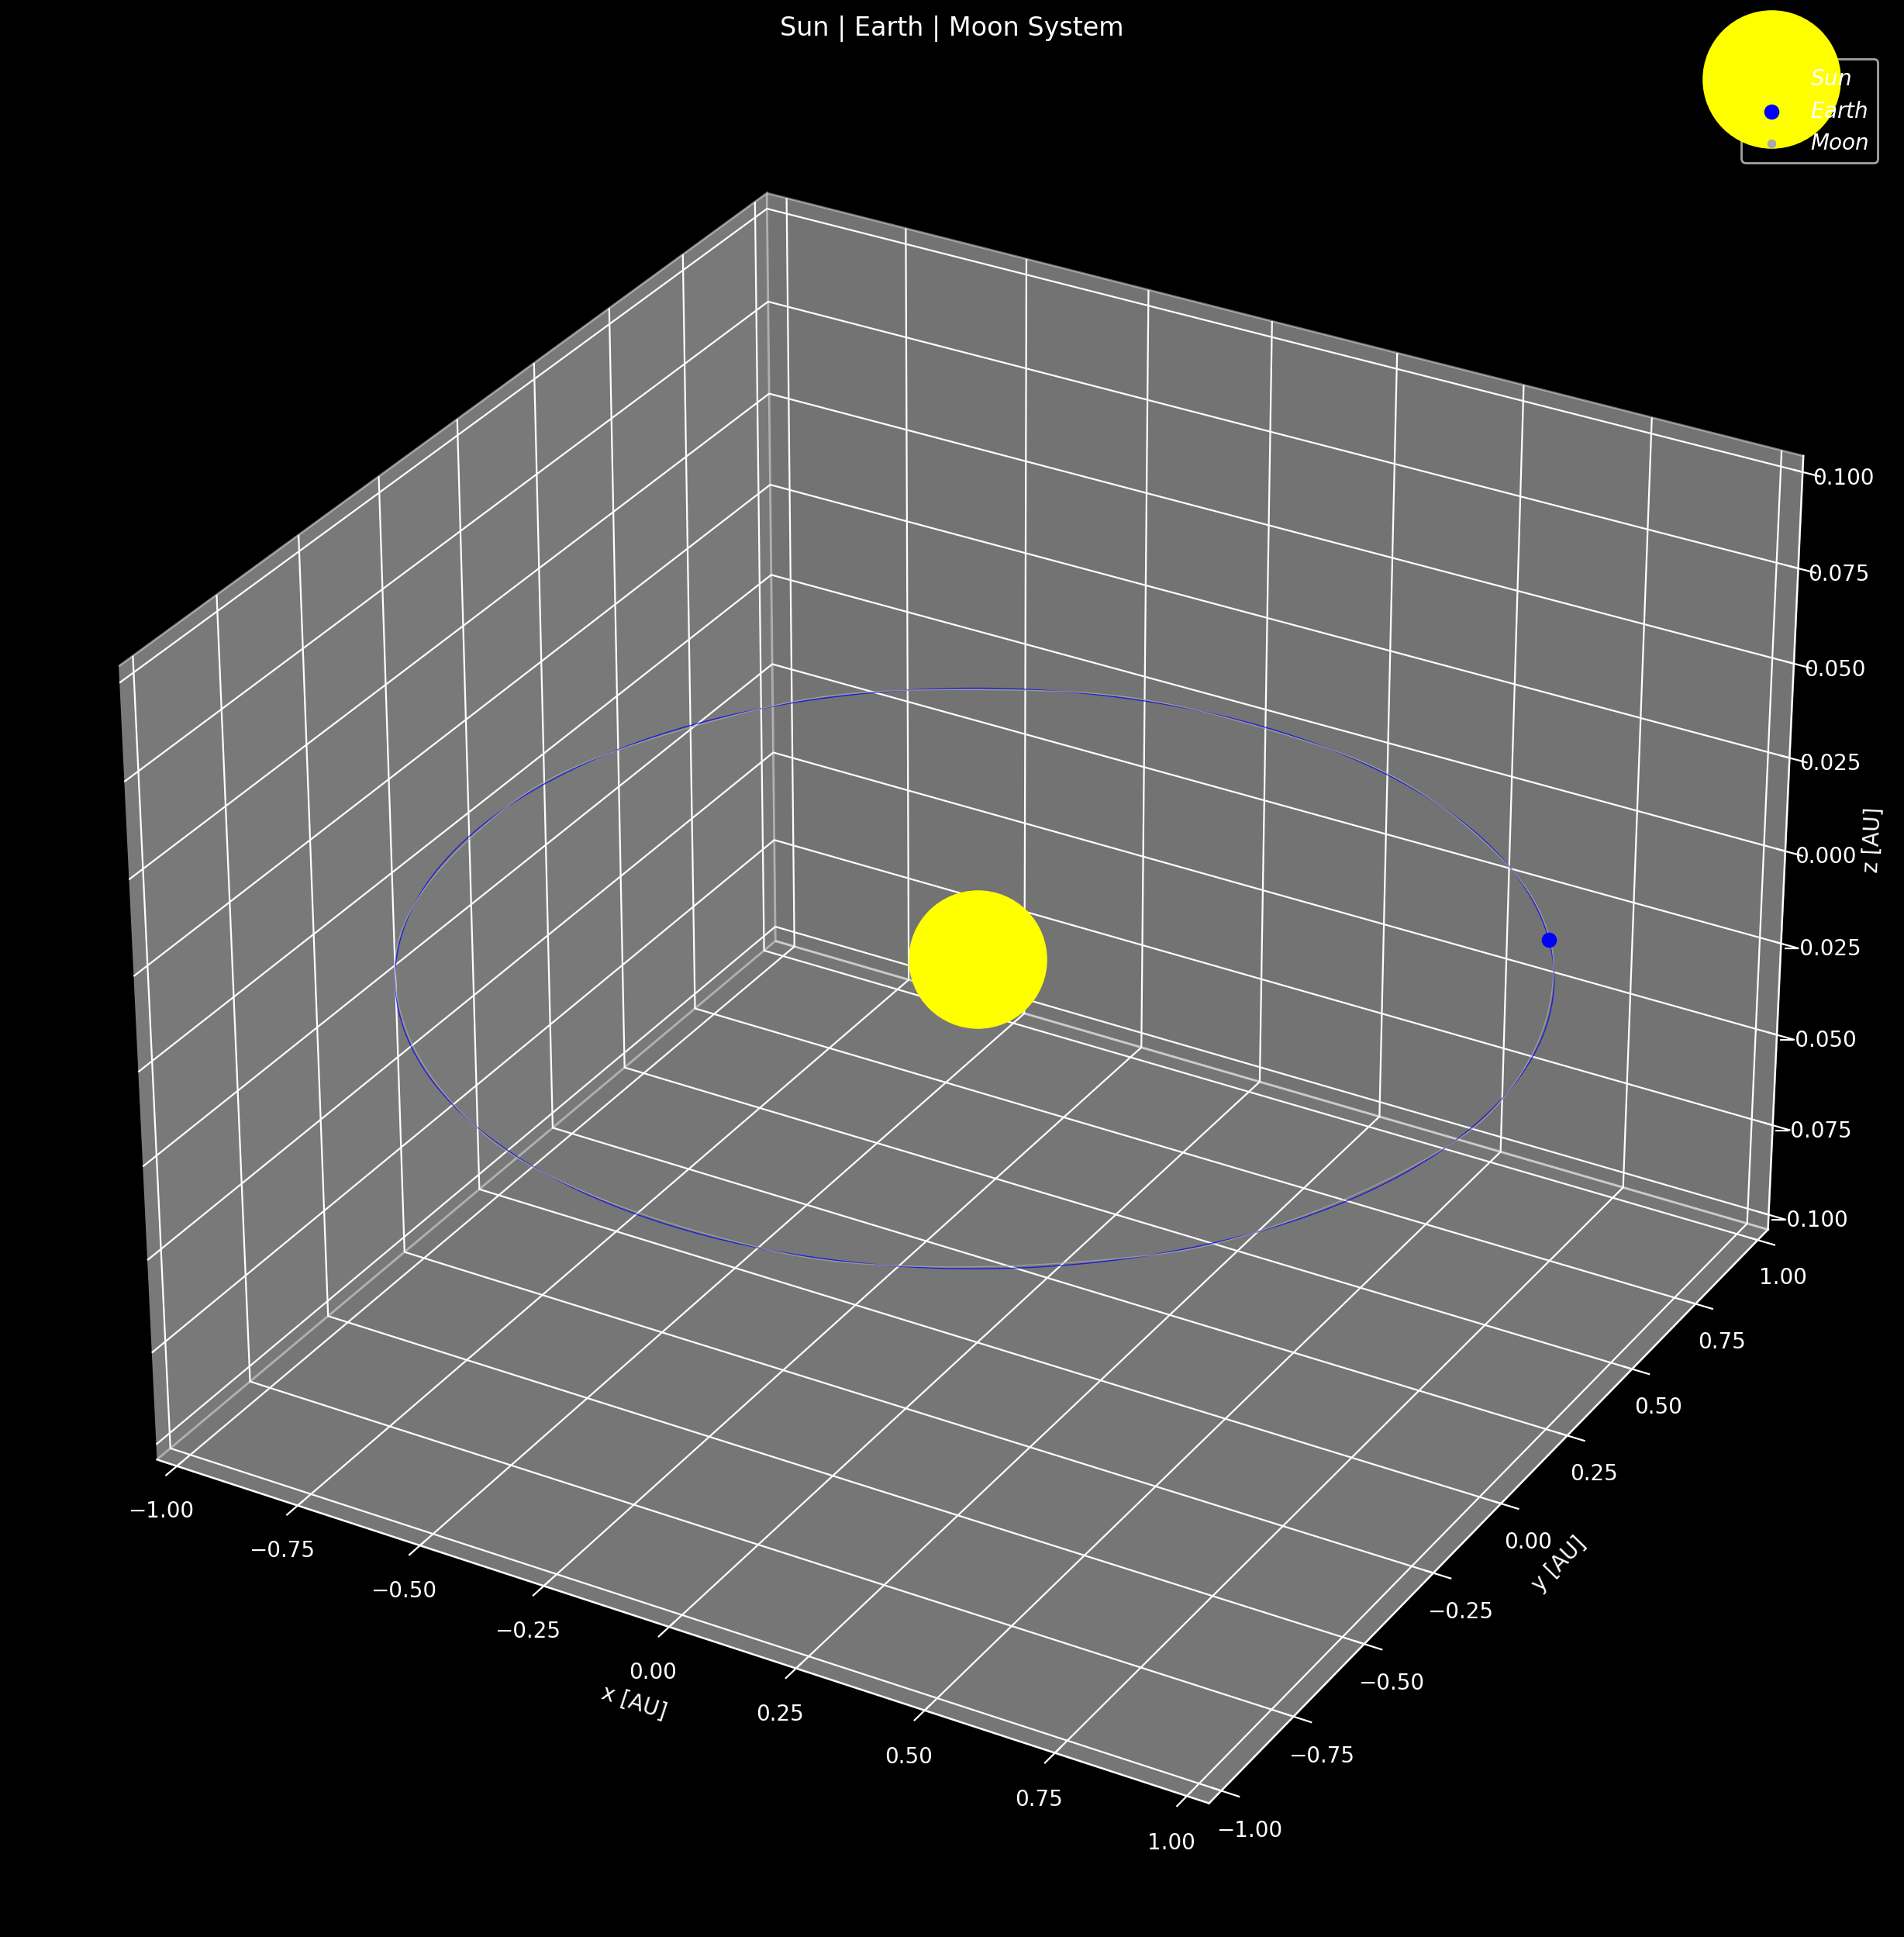

In [17]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.add_subplot(111, projection='3d')

ax.plot(sun_pos[0,:], sun_pos[1,:], sun_pos[2,:],   color='yellow', lw=0.5, alpha=0.75)
ax.plot(earth_pos[0,:], earth_pos[1,:], earth_pos[2,:], color='blue', lw=0.5, alpha=0.75)
ax.plot(moon_pos[0,:], moon_pos[1,:], moon_pos[2,:],  color='darkgray', lw=0.5, alpha=0.75)
ax.scatter(sun_pos[0,-1], sun_pos[1,-1], sun_pos[2,-1], color='yellow', s=10 * sun_radius / smallest_radius, label=r'$Sun$')
ax.scatter(earth_pos[0,-1], earth_pos[1,-1], earth_pos[2,-1], color='blue', s=10 * earth_radius / smallest_radius, label=r'$Earth$')
ax.scatter(moon_pos[0,-1], moon_pos[1,-1], moon_pos[2,-1], color='darkgray', s=10 * moon_radius / smallest_radius, label=r'$Moon$')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-0.1,0.1)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('Sun | Earth | Moon System')
plt.legend()
plt.savefig('P2a.png')

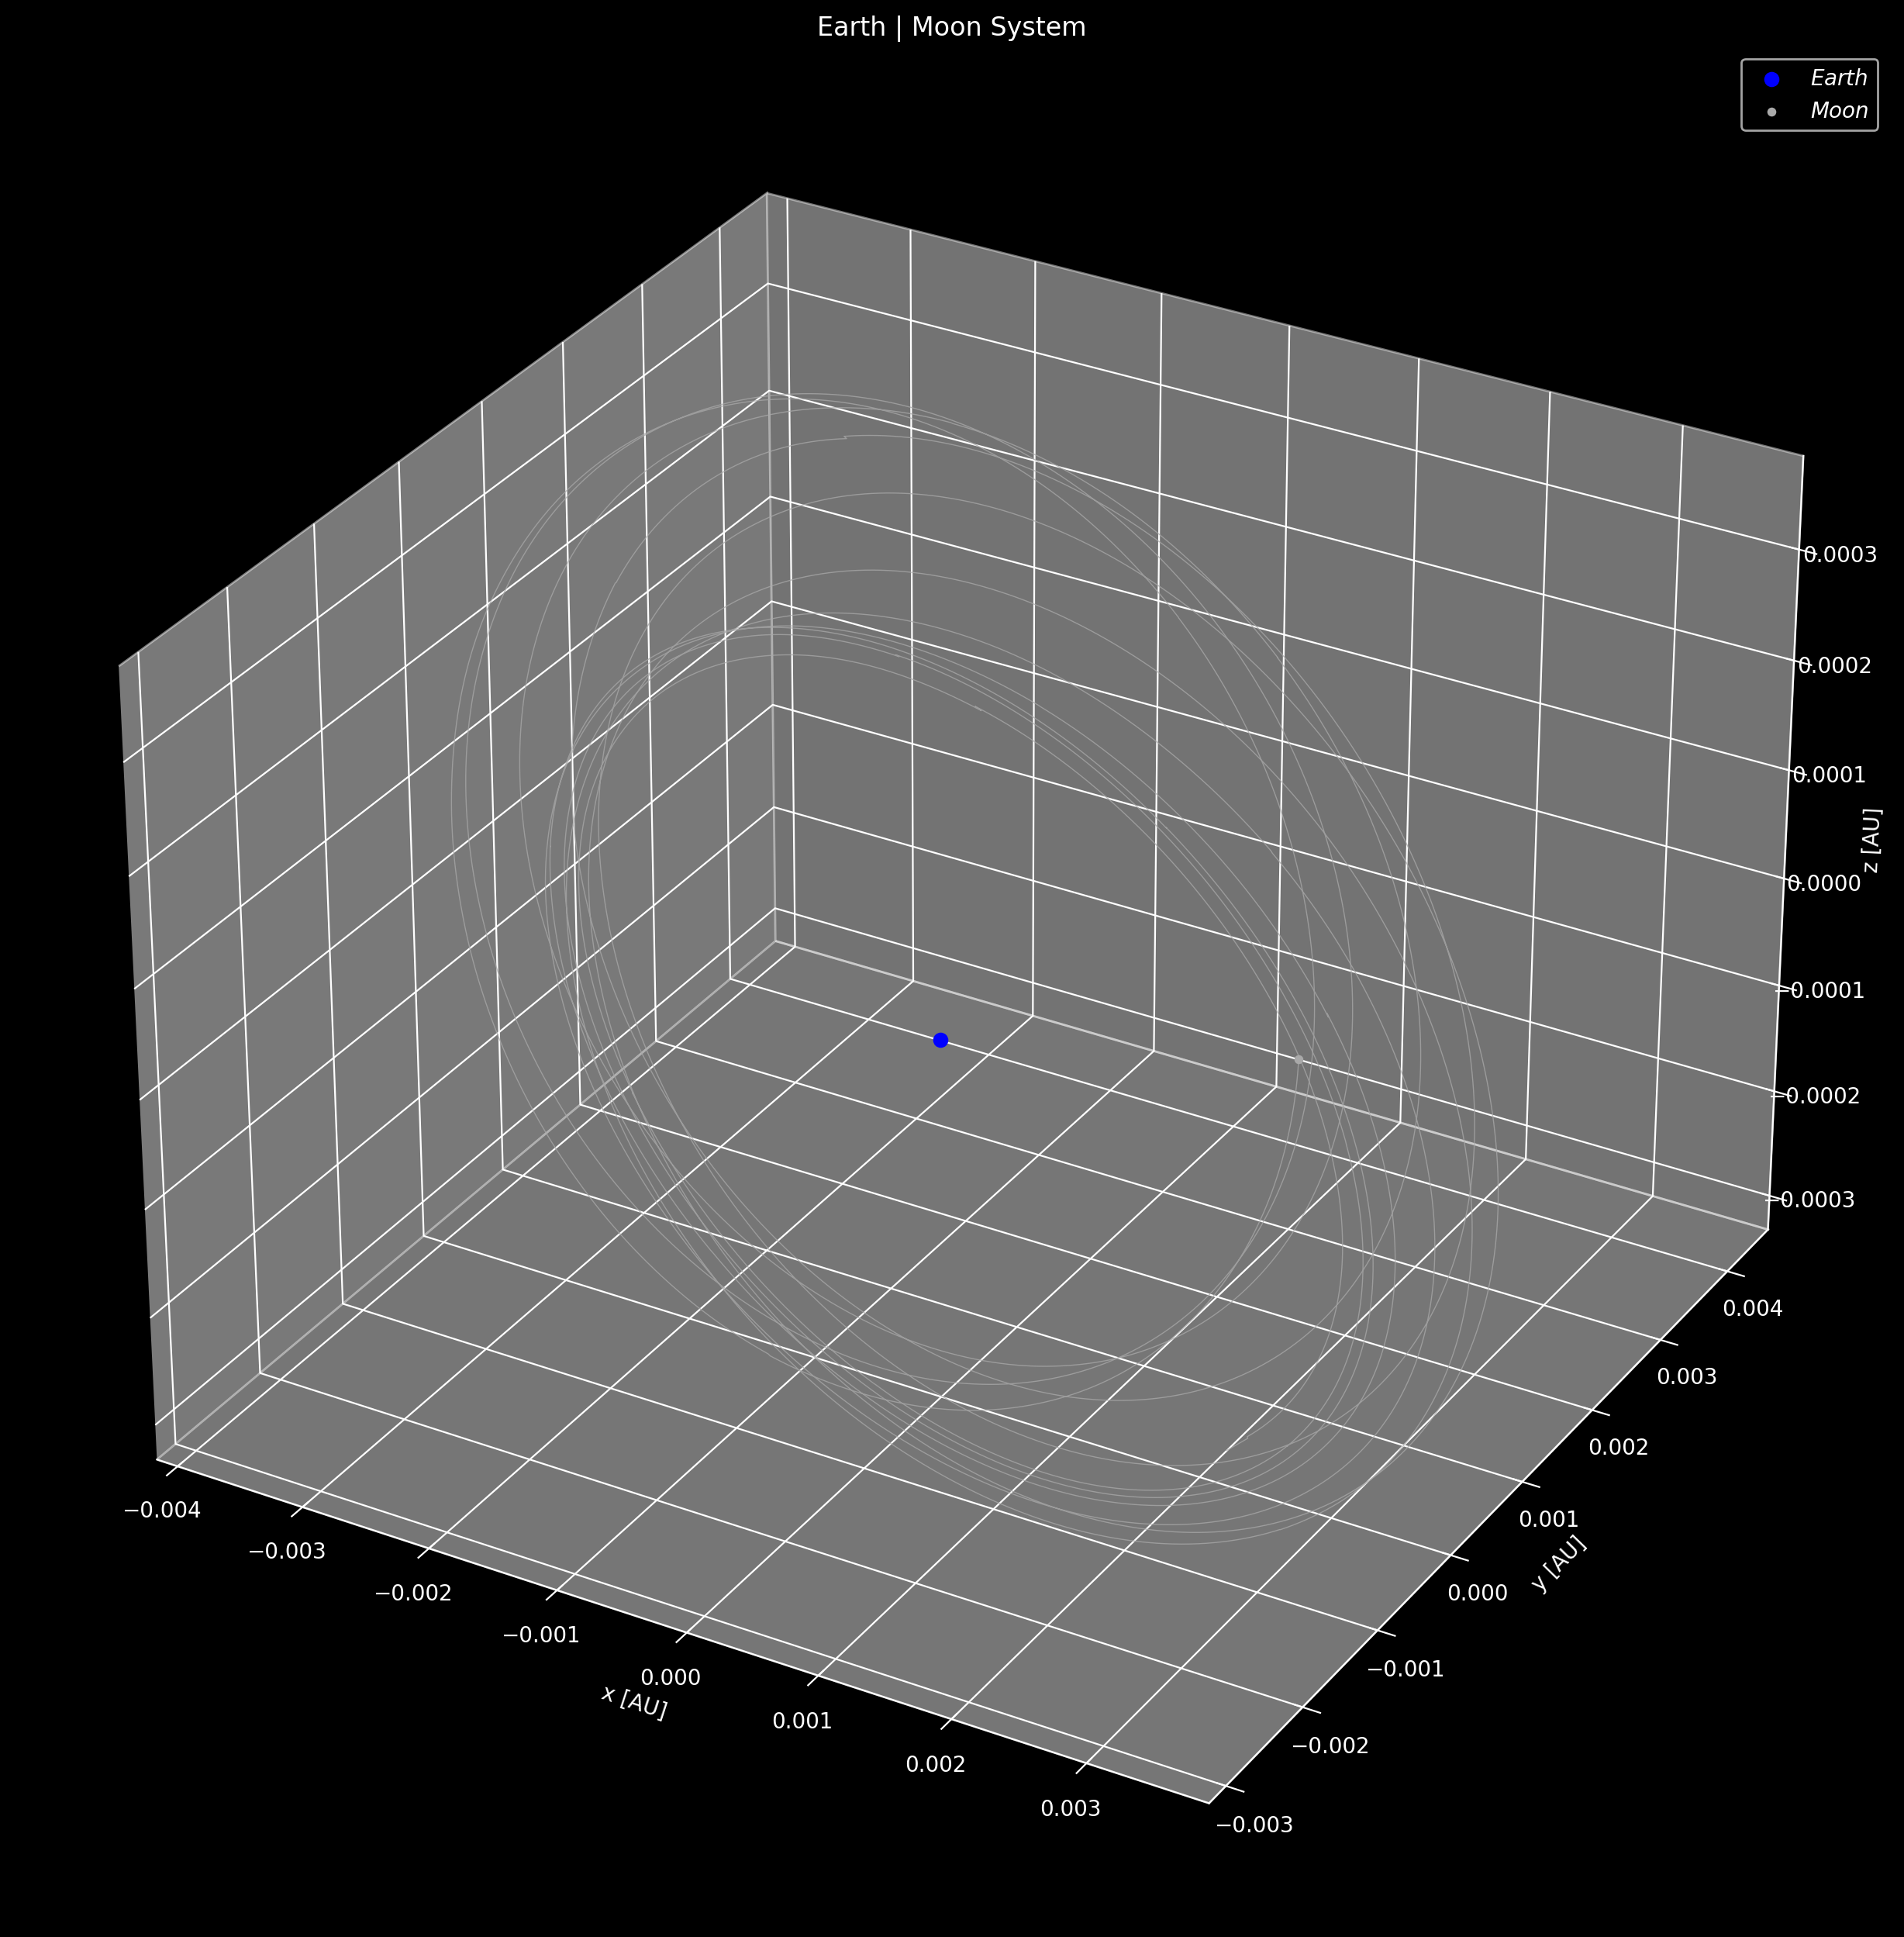

In [18]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.add_subplot(111, projection='3d')

ax.plot(moon_pos[0,:] - earth_pos[0,:], moon_pos[1,:] - earth_pos[1,:], moon_pos[2,:] - earth_pos[2,:],  color='darkgray', lw=0.5, alpha=0.75)
ax.scatter(0, 0, 0, color='blue', s=10 * earth_radius / smallest_radius, label=r'$Earth$')
ax.scatter(moon_pos[0,-1] - earth_pos[0,-1], moon_pos[1,-1] - earth_pos[1,-1], moon_pos[2,-1] - earth_pos[2,-1], color='darkgray', s=10 * moon_radius / smallest_radius, label=r'$Moon$')

ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('Earth | Moon System')

plt.legend()
plt.savefig('P2b.png')

# Problem 3
## 5.7 (p.143)

Write two programs to solve the capacitor problem of Figures 5.6 and 5.7, one using the Jacobi method and one using the SOR algorithm. For a fixed accuracy (as set by the convergence test) compare the number of iterations, $N_{\text{iter}}$, that each algorithm requires as a function of the number of grid elements, $L$. Show that for the Jacobi method $N_{\text{iter}}\sim L^2$, while with SOR $N_{\text{iter}}\sim L$.

Note that you can borrow most of the work from Lab 7, but now you have to also include the SOR algorithm in your comparisons.

# Problem 4
## 5.8 (p.147)

Extend our treatment of a point charge in a metal box to deal with the case in which the charge is located near one face of the box. Study how the equipotential contours are affected by the proximity of a grounded surface (the face of the box).

# Problem 5
## E.2 (p.510)

Calculate the period of a non-linear oscillator described by

$$\frac{d^2\theta}{dt^2}=-\sin\theta$$

by numerically integrating

$$\sqrt{8}\int_0^{\theta_m}\frac{d\theta}{\sqrt{\cos\theta-\cos\theta_m}}$$

for several values of the maximum angle $\theta_m$, using the trapezoidal rule, Simpson's rule, or the Romberg integration method.